In [1]:
### Init network Build
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

2.3.0 tf
2.4.3 keras


In [2]:
df_merged = pd.read_csv('image_metrics_031021.csv')

In [3]:
print(df_merged.shape)
df_merged.head()

(99707, 11)


,Unnamed: 0,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev
0,0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509)",-0.330689,0.098987
1,1,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022)",-0.409888,0.197881
2,2,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826)",211.508011,18.443937
3,3,lores,gmndwi,10297,SAM-2016-00139-MJF,/data/image_final2/GEE_images_final2_lores_gmn...,SAM-2016-00139-MJF,1,"(0.340306, 0.6714834)",0.340306,0.671483
4,4,hires,seasonality,8500,SAC-2016-00087,/data/image_final2/GEE_images_final2_hires_sea...,SAC-2016-00087,1,"(0.02587890625, 0.4714458509886673)",0.025879,0.471446


In [4]:
f3 = df_merged.da_num.apply(lambda x: x[:3])
f3.value_counts()

MVP    14379
MVN     9281
SAC     7953
SWG     7717
NAO     6484
MVK     6079
LRC     5317
NWO     4676
POA     4452
SAW     3385
LRH     3148
LRL     3062
SAM     3029
LRB     2889
NWK     2732
LRE     1752
SWL     1700
NAN     1674
MVM     1567
NAB     1400
NWP     1023
NWS     1020
NAP      940
SAS      874
MVR      790
SAJ      630
SWT      428
POH      340
LRP      329
NAE      290
NWW      160
LRN      157
MVS       50
Name: da_num, dtype: int64

In [144]:
dir2 = '/data/training_data4/'
train_X = [f for f in Path(dir2).iterdir()] #if 'SAW' in f.name]
print(len(train_X))

1408


In [145]:
train_X[0].name[:-4]

'SAC-2015-00882'

In [146]:
np.load(train_X[0]).shape

(1, 256, 256)

In [147]:
def get_label(da_num_i, df_merged = df_merged):
    return int(df_merged[df_merged.da_num == da_num_i].cwa_determination.iloc[0])
get_label(train_X[0].name[:-4])

0

In [148]:
train_y = [get_label(x.name[:-4]) for x in train_X]

In [149]:
print(len(train_X), len(train_y))

1408 1408


In [150]:
def load_3d(p):
    x = np.load(p)
    return np.concatenate([x,x,x]).reshape(256,256,3)
load_3d(train_X[9]).shape

(256, 256, 3)

In [151]:
arr_train_X = [load_3d(f).reshape(-1,256,256,3) for f in train_X]
arr_train_X = [x + .756 for x in arr_train_X]
arr_train_X = [x * 1/1.5 for x in arr_train_X]

#arr_train_y = np.array(train_y)

In [152]:
print(len(arr_train_X))
print(len(train_y))
print(np.mean(train_y))

1408
1408
0.4921875


In [155]:
means = [np.mean(x) for x in arr_train_X]
np.nanmean(means)
#for x in arr_train_X:
#    if np.isnan(np.mean(x)):
#        print(x)
#        for 

0.33262303

In [156]:
arr_train_X[0].shape

(1, 256, 256, 3)

In [157]:
# transform the images with vgg16
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
transformed = [vgg16_model1.predict(x) for x in arr_train_X]


In [171]:
vgg16_model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [158]:
type(transformed[0])
print(transformed[0].shape)
print(np.min(transformed[0]))
print(transformed[0][0,2,6,12:15])

(1, 8, 8, 512)
0.0
[0. 0. 0.]


Text(0.5, 1.0, 'stdev')

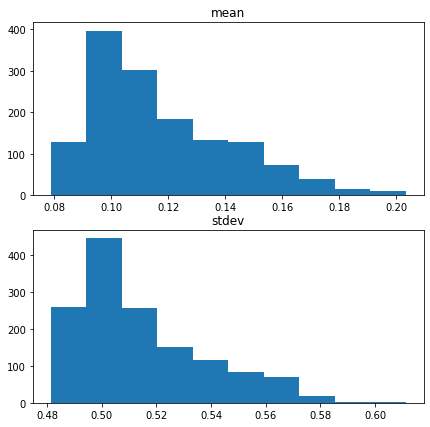

In [159]:
#investigate transformed
import matplotlib.pyplot as plt

m = [np.mean(x) for x in transformed]
s = [np.std(x) for x in transformed]
fig, ax = plt.subplots(2, figsize = (7,7))
ax[0].hist(m)
ax[0].set_title('mean')
ax[1].hist(s)
ax[1].set_title('stdev')
#mos = np.mean([np.std(x) for x in transformed])
#sos = np.std([np.std(x) for x in transformed])


In [172]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

top_model_vgg16 = Sequential()
top_model_vgg16.add(Seqential(vgg16_model1))
top_model_vgg16.add(Dense(512,activation='relu', input_shape=(8,8,512,)))
top_model_vgg16.add(LeakyReLU(alpha = 0.1))
top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.5))

#top_model_vgg16.add(Dense(512, activation='relu'))
#top_model_vgg16.add(LeakyReLU(alpha = 0.1))
#top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.2))

#top_model_vgg16.add(Dense(256, activation='relu'))
#top_model_vgg16.add(LeakyReLU(alpha = 0.1))
#top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.5))

top_model_vgg16.add(Dense(256, activation='relu'))
top_model_vgg16.add(LeakyReLU(alpha = 0.1))
top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.2))

top_model_vgg16.add(Dense(128, activation='relu'))
top_model_vgg16.add(LeakyReLU(alpha = 0.1))
top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.5))

#top_model_vgg16.add(Dense(128, activation='relu'))
#top_model_vgg16.add(LeakyReLU(alpha = 0.1))
#top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.2))

#top_model_vgg16.add(Dense(64, activation='relu'))
#top_model_vgg16.add(LeakyReLU(alpha = 0.1))
#top_model_vgg16.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.5))

#top_model_vgg16.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.2))

#top_model_vgg16.add(Dense(32, activation='relu'))
#model.add(LeakyReLU(alpha = 0.1))
#model.add(BatchNormalization())
#top_model_vgg16.add(Dropout(0.5))

top_model_vgg16.add(Flatten())
#top_model_vgg16.add(Dense(32,activation='relu'))
#top_model_vgg16.add(Dropout(0.2))
top_model_vgg16.add(Dense(1, activation = 'sigmoid')), 

#top_model_vgg16.add(Softmax())

top_model_vgg16.summary()

top_model_vgg16.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

NameError: name 'Seqential' is not defined

In [169]:
train_X_transform, train_y = np.array(transformed).reshape(-1,8,8,512), np.array(train_y)
print(train_X_transform.shape, train_y.shape)
# Train the top model with the vgg16 extracted feature
t0 = time.time()
top_model_vgg16.fit(train_X_transform, train_y, epochs=5, batch_size=412, validation_split = 0.2)
print("Train time:", time.time()-t0)

(1408, 8, 8, 512) (1408,)
Epoch 1/5
3/3 [==============================] - 0s 104ms/step - loss: 0.2670 - accuracy: 0.9352 - val_loss: 0.6913 - val_accuracy: 0.5177
Epoch 2/5
3/3 [==============================] - 0s 80ms/step - loss: 0.2593 - accuracy: 0.9538 - val_loss: 0.6921 - val_accuracy: 0.5142
Epoch 3/5
3/3 [==============================] - 0s 72ms/step - loss: 0.2494 - accuracy: 0.9636 - val_loss: 0.6918 - val_accuracy: 0.5213
Epoch 4/5
3/3 [==============================] - 0s 66ms/step - loss: 0.2976 - accuracy: 0.8925 - val_loss: 0.6914 - val_accuracy: 0.5177
Epoch 5/5
3/3 [==============================] - 0s 63ms/step - loss: 0.2800 - accuracy: 0.8934 - val_loss: 0.6991 - val_accuracy: 0.5213
Train time: 1.5748374462127686


In [167]:
np.mean(train_y)

0.4921875

In [137]:
top_model_vgg16.predict(train_X_transform)

array([[0.5530647 ],
       [0.615571  ],
       [0.6014415 ],
       [0.5732824 ],
       [0.4842569 ],
       [0.554946  ],
       [0.6046836 ],
       [0.56508374],
       [0.6013986 ],
       [0.57375604],
       [0.5620803 ],
       [0.53165287],
       [0.5759678 ],
       [0.58225673],
       [0.5950668 ],
       [0.62529445],
       [0.5620189 ],
       [0.57533544],
       [0.572263  ],
       [0.5560221 ],
       [0.55870026],
       [0.5573043 ],
       [0.55465055],
       [0.57555956],
       [0.5653618 ],
       [0.57306963],
       [0.55964386],
       [0.53954643],
       [0.6060331 ],
       [0.5832075 ],
       [0.56680524],
       [0.5818143 ],
       [0.53141016],
       [0.5784481 ],
       [0.5637895 ],
       [0.5815287 ],
       [0.5837059 ],
       [0.5913999 ],
       [0.5827023 ],
       [0.5478481 ],
       [0.59595424],
       [0.579196  ],
       [0.5560963 ],
       [0.5728743 ],
       [0.57457125],
       [0.5835815 ],
       [0.53326875],
       [0.548

In [142]:
# baseline model
# create model
model22 = Sequential()
model22.add(Flatten(input_shape=(8,8,512,)))
model22.add(Dense(512,activation='relu'))
model22.add(Dense(1, activation='sigmoid'))
# Compile model
model22.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model22.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 512)               16777728  
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 513       
Total params: 16,778,241
Trainable params: 16,778,241
Non-trainable params: 0
_________________________________________________________________


In [139]:
train_X_transform, train_y = np.array(transformed).reshape(412,8,8,512), np.array(train_y)
print(train_X_transform.shape, train_y.shape)

(412, 8, 8, 512) (412,)


In [170]:
# Train the top model with the vgg16 extracted features
t0 = time.time()
model22.fit(train_X_transform, train_y, epochs=5, batch_size=412)#, validation_split = 0.2)
print("Train time:", time.time()-t0)

Epoch 1/5
4/4 [==============================] - 0s 34ms/step - loss: 8.4017 - accuracy: 0.4837
Epoch 2/5
4/4 [==============================] - 0s 28ms/step - loss: 3.2754 - accuracy: 0.5078
Epoch 3/5
4/4 [==============================] - 0s 26ms/step - loss: 0.9847 - accuracy: 0.5128
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: 1.1488 - accuracy: 0.4922
Epoch 5/5
4/4 [==============================] - 0s 23ms/step - loss: 0.7131 - accuracy: 0.5213
Train time: 1.3266499042510986


In [75]:
!nvidia-smi

Thu Mar 11 01:47:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    71W / 149W |  10877MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [132]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model3 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))

vgg16_model1.trainable = False
#vgg16_model2.trainable = False
#vgg16_model3.trainable = False

In [137]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax
from keras.models import Model, Sequential

num_channels = 3
input = Input(shape=(256,256, num_channels))

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)

# create looping so that vgg16 model input is created ie 256,256,3
print(input.shape)
#out = Lambda(lambda x: x[:,:,:,i:i+3])(input)
#print(out.shape)

# Setting up your layers in each branch: (currently each branch is identical architecture.)
out = Sequential(vgg16_model1)(input)   # use pretrained and loaded vgg16

print(out.shape)
out = Dense(10)(out)
print(out.shape)
out = Flatten()(out)
print(out.shape)
branch_outputs.append(out)

# Concatenating the branches outputs:
#out = Concatenate()(branch_outputs)
#print(out.shape)

# Add final dense layers and softmax
out = Dense(20)(out)
out = Dense(10)(out)
print(out.shape)
out = Dense(6)(out)
out = Dense(2)(out)
print(out.shape)
out = Softmax()(out)
print(out.shape)

(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 10)
(None, 2)
(None, 2)


In [138]:
model = Model(inputs=input, outputs=out)   
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_16 (Dense)             (None, 8, 8, 10)          5130      
_________________________________________________________________
flatten_4 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                12820     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 6)                

In [141]:
opt = keras.optimizers.Adam()

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [31]:
import time
test_input = np.random.rand(256,256,3)
test_input = test_input.reshape(1, 256,256, 3)
print(test_input.shape)
t0 = time.time()
print(model.predict(test_input))
print(f"time taken: {time.time()-t0} seconds")

(1, 256, 256, 3)
[[0.1622066  0.83779347]]
time taken: 6.368284225463867 seconds


In [142]:
t0 = time.time()
model.fit(arr_train_X, arr_train_y, epochs=5, batch_size=64, validation_split = 0.2)#, workers=4, use_multiprocessing=True)
print("Train time:", time.time()-t0)

Epoch 1/5
6/6 [==============================] - 4s 590ms/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Epoch 2/5
6/6 [==============================] - 3s 543ms/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Epoch 3/5
6/6 [==============================] - 3s 545ms/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Epoch 4/5
6/6 [==============================] - 3s 542ms/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Epoch 5/5
6/6 [==============================] - 3s 542ms/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Train time: 20.48793864250183


In [33]:
vgg_layer = model.get_layer(name='sequential_2', index=None)
#model.get_layer(name='dense_8', index=None).trainable = False
model.get_layer(name='dense_9', index=None).trainable = False
model.get_layer(name='dense_10', index=None).trainable = False
model.get_layer(name='dense_11', index=None).trainable = False
model.get_layer(name='dense_12', index=None).trainable = False

vgg_layer.trainable = True
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_9 (Dense)              (None, 8, 8, 10)          5130      
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                12820     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 126       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                

In [34]:
model.fit(arr_train_X, arr_train_y, epochs=5, batch_size=16, validation_split = 0.2)#, workers=4, use_multiprocessing=True)


Epoch 1/5
9/9 [==============================] - 15s 2s/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 2/5
9/9 [==============================] - 4s 480ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 3/5
9/9 [==============================] - 4s 481ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 4/5
9/9 [==============================] - 4s 481ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 5/5
9/9 [==============================] - 4s 479ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882


In [25]:
np.mean(arr_train_y)

0.5952380952380952

In [21]:
x = model.predict_on_batch(arr_train_X[:10])
print(x)

[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.1937740e-31]
 [1.0000000e+00 1.2457646e-30]
 [1.0000000e+00 3.6220060e-25]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]]
